**X-Ray classification**

**Exploratory data analysis**

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. 

You must use at least **2 different architectures**,
* one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and 
* one with a popular CNN pre-trained CNN model (e.g., VGG-19, ResNet, etc.). 

Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found [here](https://stanfordmlgroup.github.io/competitions/mura/). To download the dataset you must fill out a form, so complete this action as soon as possible.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [22]:
# mount data from gdrive and change directory
data_path = 'data/MURA-v1.1/'
directory = 'data/'
! pwd

/tf


# Data  munging

In [23]:
def import_data(path):
  df_imgs = pd.read_csv(path,
                        header=None,
                        names=['img_path'])
  df = pd.DataFrame(df_imgs['img_path'].str.split('/').to_list())
  df.rename(columns={2:'bodypart',3:'patient',4:'study',5:'img_path'}, 
            inplace=True)
  df.drop(columns=[0,1],inplace=True)
  df['img_path'] = df_imgs['img_path']
  result_df = pd.DataFrame(df['study'].str.split('_').to_list())[1]
  df['result'] = result_df
  labels = np.where(df['result']=='positive',1,0)
  df['class'] = labels
  df['diagnosis'] = np.where(df['result']=='positive','abnormal','normal')
  return df

In [24]:
# train and test dataset

train = import_data(data_path + 'train_image_paths.csv')
test = import_data(data_path  + 'valid_image_paths.csv')

In [25]:
# train and validation set for each per bodypart
def train_validation_bodyparts(bodypart, df, percentage):
    df_bp = df[df['bodypart'] == bodypart]
    # unique patients for each bodypart
    patients = df_bp['patient'].unique()
    # percentage of patients for validation data
    idx_size = int(percentage * len(patients))
    idx = np.random.choice(len(patients), size=idx_size, replace=False)
    valid_patients = patients[idx]
    valid_flag = df_bp['patient'].isin(valid_patients)
    # training and validation sets for this specific bodypart
    # based on the patients selected
    train_df = df_bp[~valid_flag].reset_index()
    valid_df = df_bp[valid_flag].reset_index()

    return train_df, valid_df

In [26]:
# dictionary for training and validation set
bodyparts_train_validation_dict = {}
for bodypart in set(train.bodypart):
    bodyparts_train_validation_dict[bodypart] = train_validation_bodyparts(bodypart, 
                                                                   train,
                                                                   0.1)

## Data Generator

In [27]:
train_generator = ImageDataGenerator(
    rescale = 1./255,
#     rotation_range = 30,
#     horizontal_flip = True
    )
valid_generator = ImageDataGenerator(
    rescale = 1./255
    )

### Per part of the body

In [28]:
def generate_data(df, 
                  bodypart, 
                  generator,
                  indication): # 0 for train and 
                               # 1 for validation
      if type(df) == dict:
        dataframe = df[bodypart][indication]
      if type(df) == pd.core.frame.DataFrame:
        dataframe = df[df['bodypart'] == bodypart]
      generated = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = directory,
        x_col = 'img_path',
        y_col = 'class',
        class_mode = 'raw',
        batch_size = 32,
        seed = 34,
        target_size=(320,320)
      )
      return generated

In [29]:
train_generators = {}
valid_generators = {}
test_generators = {}
for bodypart in set(test.bodypart):
  train_generators[bodypart] = generate_data(bodyparts_train_validation_dict,
                                  bodypart,
                                  train_generator,
                                  0)
  valid_generators[bodypart] = generate_data(bodyparts_train_validation_dict,
                                  bodypart,
                                  valid_generator,
                                  1)
  test_generators[bodypart] = generate_data(test,
                                  bodypart,
                                  valid_generator,
                                  1)  

Found 7550 validated image filenames.
Found 829 validated image filenames.
Found 563 validated image filenames.
Found 4613 validated image filenames.
Found 493 validated image filenames.
Found 461 validated image filenames.
Found 8765 validated image filenames.
Found 987 validated image filenames.
Found 659 validated image filenames.
Found 1639 validated image filenames.
Found 186 validated image filenames.
Found 301 validated image filenames.
Found 1146 validated image filenames.
Found 126 validated image filenames.
Found 288 validated image filenames.
Found 4413 validated image filenames.
Found 518 validated image filenames.
Found 465 validated image filenames.
Found 4980 validated image filenames.
Found 563 validated image filenames.
Found 460 validated image filenames.


# EDA
## Check balance of the dataset

In [30]:
def plot_hist_region(df):
  fig  = plt.figure(figsize=(8,4), dpi = 150)
  df['bodypart'].hist(bins = 13, color = 'red')
  plt.xticks(rotation = 90)
  # fig.savefig('hist_train.png', dpi = 150)
  # files.download("hist_train.png")

In [31]:
plot_hist_region(train)

In [32]:
plot_hist_region(test)

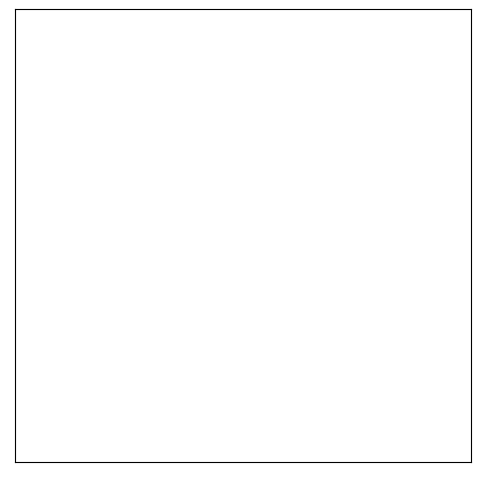

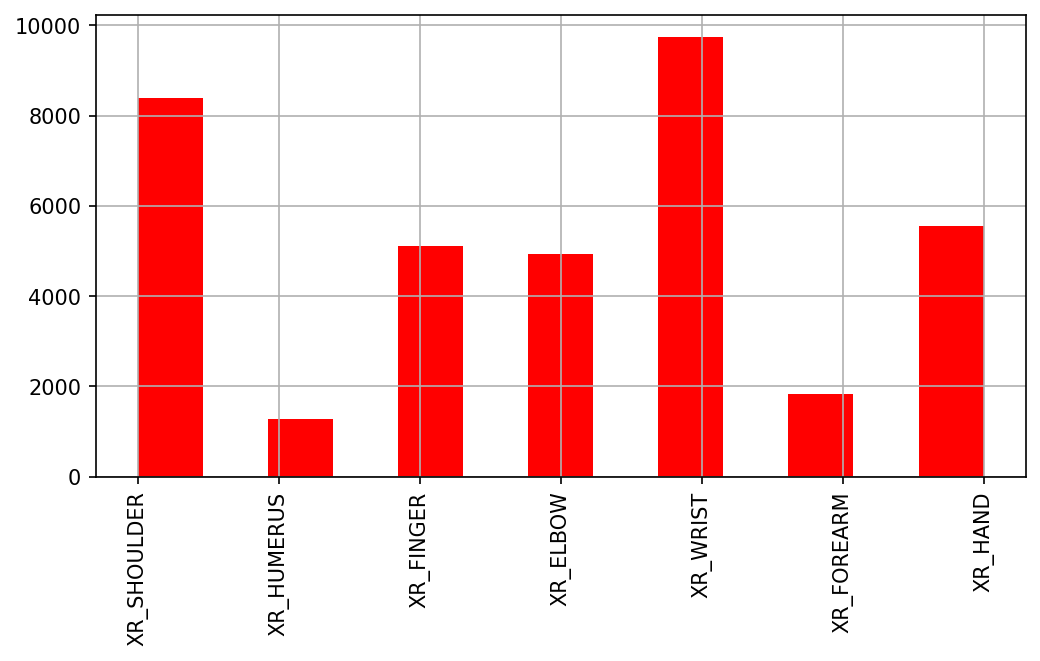

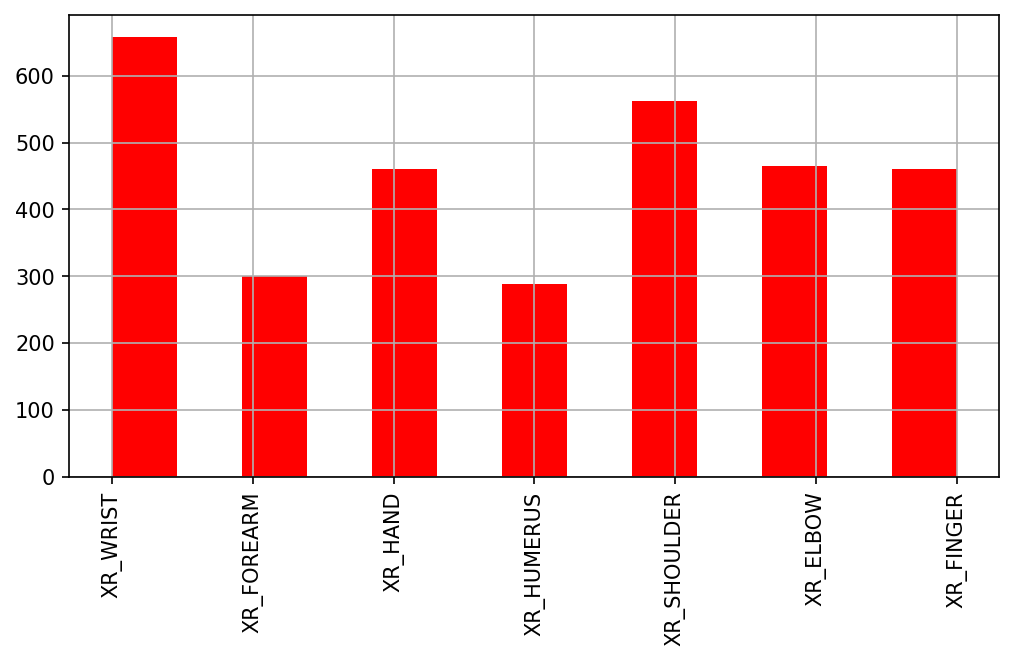

<Figure size 1200x600 with 0 Axes>

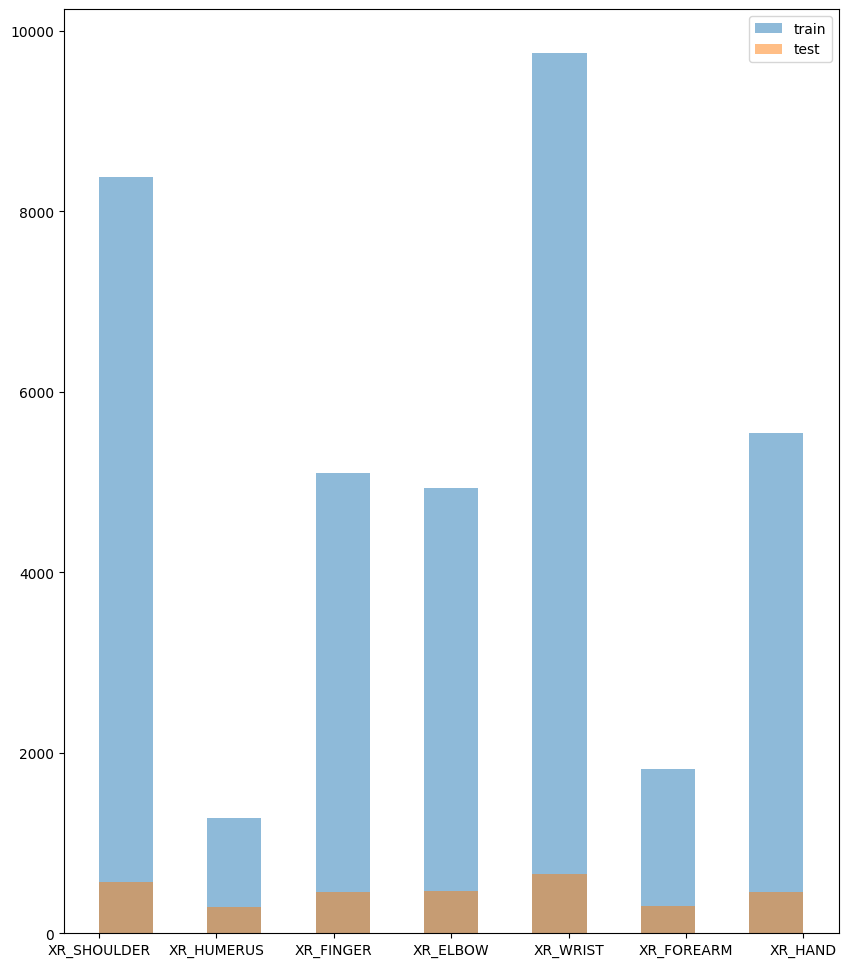

In [33]:
fig  = plt.figure(figsize=(8,4), dpi = 150)
plt.figure(figsize=(10,12))
plt.hist(train['bodypart'], alpha=0.5, bins = 13, label='train')
plt.hist(test['bodypart'], alpha=0.5, bins = 13, label='test')
plt.legend()
plt.show()

In [34]:
def class_counts(df):
  patients_per_bodypart = df.groupby('bodypart')['patient'].count().reset_index()
  patients_per_bodypart.rename(columns={'patient':'patient_count'},inplace=True)
  abnormalities_per_bodypart = df.groupby('bodypart')['class'].sum().reset_index()
  abnormalities_per_bodypart.rename(columns={'class':'abnorm_count'},inplace=True)
  total = patients_per_bodypart.merge(abnormalities_per_bodypart)
  total['normal_count'] = total['patient_count'] - total['abnorm_count']
  total['abnorm_percentage'] = (total['abnorm_count']/total['patient_count'])
  total['normal_percentage'] = (total['normal_count']/total['patient_count'])
  return total

In [35]:
def barplot_per_bodypart(df, name, width): 
  xtick_labels = df['bodypart']
  xtick_position = np.arange(len(xtick_labels))
  fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
  abnorm_bars = ax.bar(xtick_position - width/2, 
                       df['abnorm_count'], 
                       width=width,  
                       label='Abnormal')
  normal_bars = ax.bar(xtick_position + width/2,
                       df['normal_count'], 
                       width=width, 
                       label='Normal')

  for rect in abnorm_bars + normal_bars:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width() / 2.0, 
               height, 
               f'{height:.0f}', 
               ha='center', 
               va='bottom')

  ax.set_title('%s Set'% name)
  ax.set_ylabel('Count')
  ax.set_xticks(xtick_position)
  ax.set_xticklabels(xtick_labels)
  ax.legend()

  fig.suptitle('Count of Abnormal and Normal Results per Bodypart (%s) set' % name)
  plt.show()

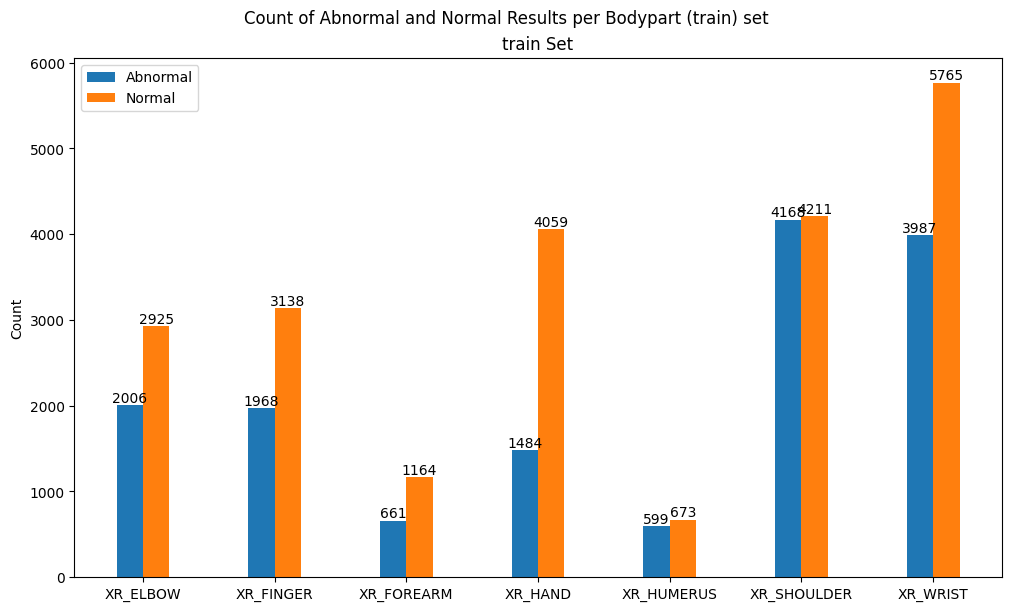

In [36]:
stats_train = class_counts(train)
stats_test = class_counts(test)
barplot_per_bodypart(stats_train, "train", 0.2)

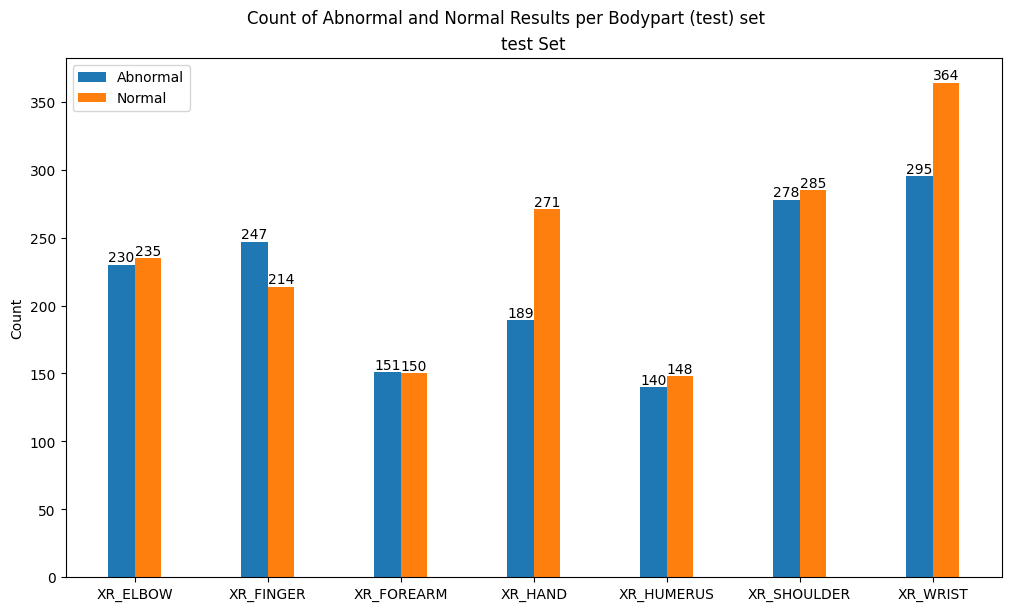

In [37]:
barplot_per_bodypart(stats_test, "test", 0.2)

In [38]:
def balance_calculator(name, df):
    train, valid = df
    print('Training set')
    negative = round(sum(train['class']== 0) / len(train), 2) * 100
    positive = round(sum(train['class']== 1) / len(train), 2) * 100
    print(f"{name}: {negative} % of normal X-rays.")
    print(f"{name}: {positive} % of abnormal X-rays.")
    print('Validation set')
    negative = round(sum(valid['class']== 0) / len(valid), 2) * 100
    positive = round(sum(valid['class']== 1) / len(valid), 2) * 100
    print(f"{name}: {negative} % of normal X-rays.")
    print(f"{name}: {positive} % of abnormal X-rays.")
    print('\n')
    pass 

In [39]:
for bodypart, datasets in bodyparts_train_validation_dict.items():
    balance_calculator(bodypart, datasets)

Training set
XR_SHOULDER: 51.0 % of normal X-rays.
XR_SHOULDER: 49.0 % of abnormal X-rays.
Validation set
XR_SHOULDER: 48.0 % of normal X-rays.
XR_SHOULDER: 52.0 % of abnormal X-rays.


Training set
XR_FINGER: 61.0 % of normal X-rays.
XR_FINGER: 39.0 % of abnormal X-rays.
Validation set
XR_FINGER: 62.0 % of normal X-rays.
XR_FINGER: 38.0 % of abnormal X-rays.


Training set
XR_WRIST: 59.0 % of normal X-rays.
XR_WRIST: 41.0 % of abnormal X-rays.
Validation set
XR_WRIST: 61.0 % of normal X-rays.
XR_WRIST: 39.0 % of abnormal X-rays.


Training set
XR_FOREARM: 64.0 % of normal X-rays.
XR_FOREARM: 36.0 % of abnormal X-rays.
Validation set
XR_FOREARM: 63.0 % of normal X-rays.
XR_FOREARM: 37.0 % of abnormal X-rays.


Training set
XR_HUMERUS: 53.0 % of normal X-rays.
XR_HUMERUS: 47.0 % of abnormal X-rays.
Validation set
XR_HUMERUS: 51.0 % of normal X-rays.
XR_HUMERUS: 49.0 % of abnormal X-rays.


Training set
XR_ELBOW: 60.0 % of normal X-rays.
XR_ELBOW: 40.0 % of abnormal X-rays.
Validation se

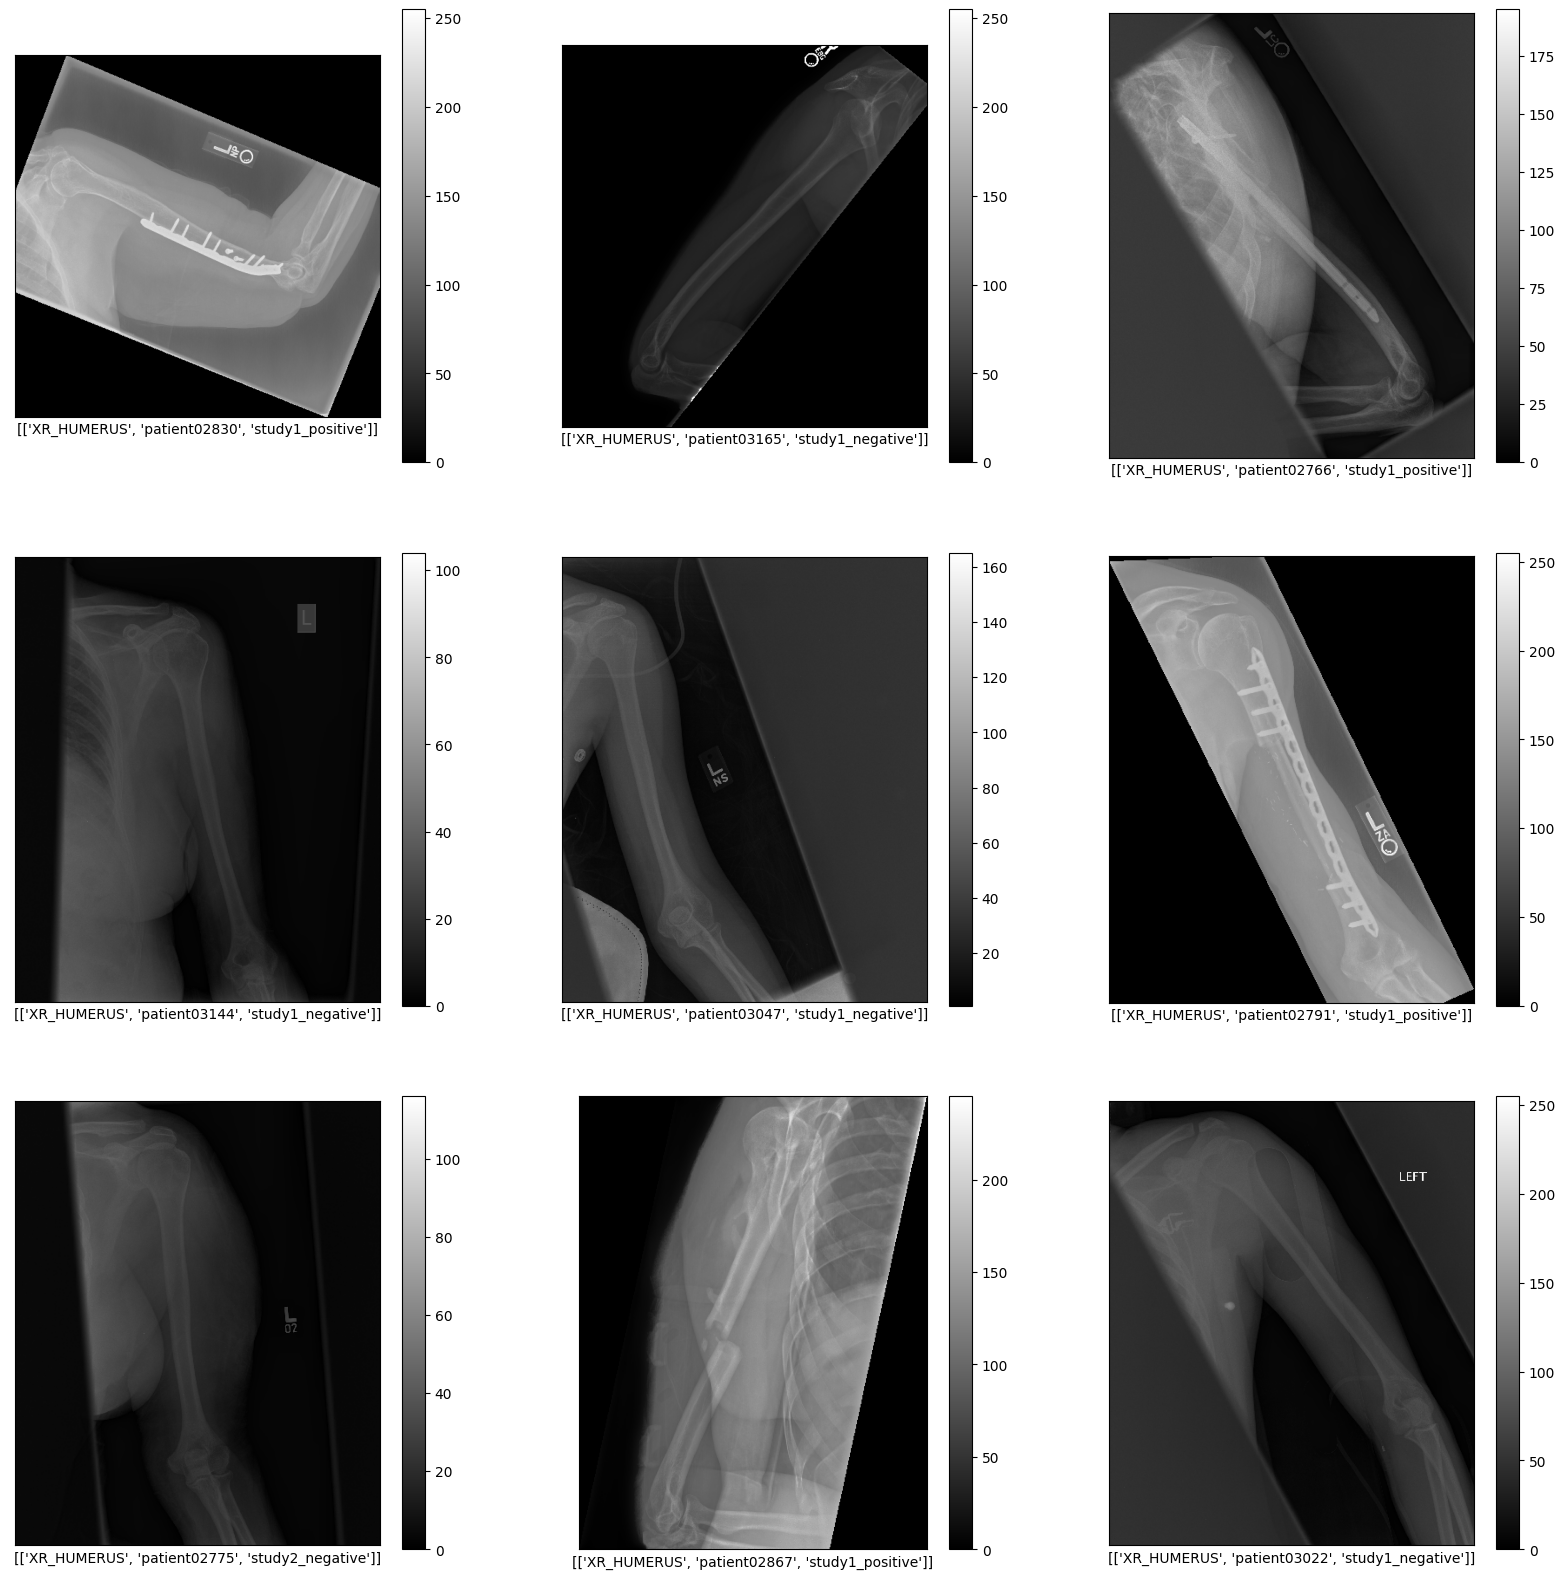

In [40]:
x_train_HUMERUS = bodyparts_train_validation_dict['XR_HUMERUS'][0]['img_path']
y_train_HUMERUS = bodyparts_train_validation_dict['XR_HUMERUS'][0]['img_path']

plt.figure(figsize=(20,20))
for i in range(9):
    n = np.random.randint(1,len(x_train_HUMERUS))
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(load_img(directory+x_train_HUMERUS[n]), 
               cmap='gray')
    plt.colorbar()
    plt.xlabel([y_train_HUMERUS[n].split('/')[2:5]])
    plt.savefig("humerus_xrays.png")
plt.show()